<a href="https://colab.research.google.com/github/Kiran771/AIvsHumanWrittenText/blob/main/ai44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wordcloud matplotlib

In [1]:
# import all the required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,roc_curve, roc_auc_score,ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

In [2]:
model = LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000)# load dataset
df=pd.read_csv('/content/AI-Human.csv')

In [3]:
# view the dataset
df.head()

,title,abstract,label
0,Epigenetic inheritance of circadian period in ...,\n\nThis study focuses on the epigenetic inher...,1
1,Pediatric Airway Stent Designed to Facilitate ...,Objective: The goal was to develop a pediatric...,0
2,Infection prevention and control in paediatric...,Transmission of infection in the paediatric of...,0
3,"Correlation between thyroid function, testoste...",STUDY DESIGN: Prospective case series. OBJECTI...,0
4,Natural intertypic and intratypic recombinants...,\n\nThis study aims to analyze the recombinant...,1


In [4]:
df.shape

(28662, 3)

In [5]:
df.dtypes

,0
title,object
abstract,object
label,int64


In [6]:
# check class imbalance
label_counts=df['label'].value_counts()

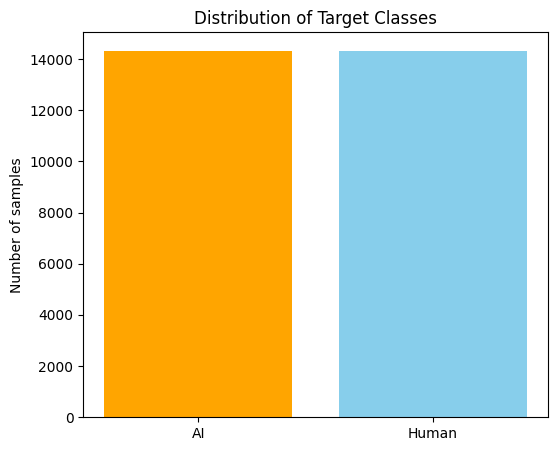

In [7]:
plt.figure(figsize=(6,5))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'orange'])
plt.xticks(label_counts.index, ['Human', 'AI'])
plt.ylabel('Number of samples')
plt.title('Distribution of Target Classes')
plt.show()

In [8]:
# combine title and abstract column
df['text'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')


In [9]:
df['text'][1]

'Pediatric Airway Stent Designed to Facilitate Mucus Transport and Atraumatic Removal Objective: The goal was to develop a pediatric airway stent for treating tracheobronchomalacia that could be used as an alternative to positive pressure ventilation. The design goals were for the stent to allow mucus flow and to resist migration inside the airways, while also enabling easy insertion and removal. Methods: A helical stent design, together with insertion and removal tools, is presented. A mechanics model of stent compression is derived to assist in selecting stent design parameters (pitch and wire diameter) that provide the desired amount of tracheal support, while introducing the minimal amount of foreign material into the airway. Worst-case airway area reduction with stent support is investigated experimentally using a pressurized tracheal phantom matched to porcine tracheal tissue properties. The stent design is then evaluated in a porcine in vivo experiment. Results: Phantom testing 

In [10]:
# Textpreprocessing step
def preprocess_text(text):

  # handle missing values
  if pd.isna(text):
    return ""
  # convert to string
  text=str(text)

  # remove HTML tags
  text = re.sub(r'<[^>]+>', ' ', text)

  # remove URLs
  text = re.sub(r'http[s]?://\S+', ' ', text)

  # remove email address
  text = re.sub(r'\S+@\S+', ' ', text)


  # replace multiple newlines with single space
  text = re.sub(r'\n+',' ', text )

  # Replace tabs with space
  text = re.sub(r'\t+', ' ', text)

  # remove excessive spaces 3+ to 1
  text = re.sub(r' {3,}', ' ', text)

  # remove leading or trailing whitespace
  text=text.strip()

  return text

In [11]:
df['clean_text']=df['text'].apply(preprocess_text)

In [12]:
## separating feature and target column
x=df['clean_text']
y=df['label']

In [13]:
## split the dataset into train and test
x_temp,x_test,y_temp,y_test=train_test_split(x,y,test_size=0.10,random_state=42,stratify=y)

In [14]:
## split the training set into train and validaton
x_train,x_val,y_train,y_val=train_test_split(x_temp,y_temp,test_size=0.10,random_state=42,stratify=y_temp)

In [15]:
## initialize tfid
vectorizer=TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    # ngram_range=(1,1),
    max_features=2000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.85
)

In [16]:
## fit and transform the train set on TfIdf
x_train_tfidf=vectorizer.fit_transform(x_train)

In [17]:
vocab_size = len(vectorizer.vocabulary_)
print("Vocabulary size:", vocab_size)

Vocabulary size: 2000


In [18]:
## Apply tfidf on validation and test set
x_val_tfidf=vectorizer.transform(x_val)
x_test_tfidf=vectorizer.transform(x_test)

In [19]:
feature_names = np.array(vectorizer.get_feature_names_out())

In [20]:
def wordcloud_top_features(X, y, class_label, feature_names, n=50, colormap='Blues'):

    # Ensure y is a NumPy array
    y_array = y.to_numpy() if hasattr(y, 'to_numpy') else np.array(y)

    # Get indices for the selected class
    class_indices = np.where(y_array == class_label)[0]

    # Sum TF-IDF values for the class
    class_sum = X[class_indices].sum(axis=0)
    class_sum_array = np.asarray(class_sum).flatten()

    # Get top N indices
    top_idx = class_sum_array.argsort()[::-1][:n]

    # Create dictionary for WordCloud
    word_freq = {feature_names[i]: class_sum_array[i] for i in top_idx}

    # Generate WordCloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap=colormap)
    wc.generate_from_frequencies(word_freq)

    return wc


In [ ]:
feature_names = vectorizer.get_feature_names_out()
wc_human = wordcloud_top_features(x_train_tfidf, y_train, class_label=0, feature_names=feature_names, n=50, colormap='Blues')
wc_ai    = wordcloud_top_features(x_train_tfidf, y_train, class_label=1, feature_names=feature_names, n=50, colormap='Oranges')


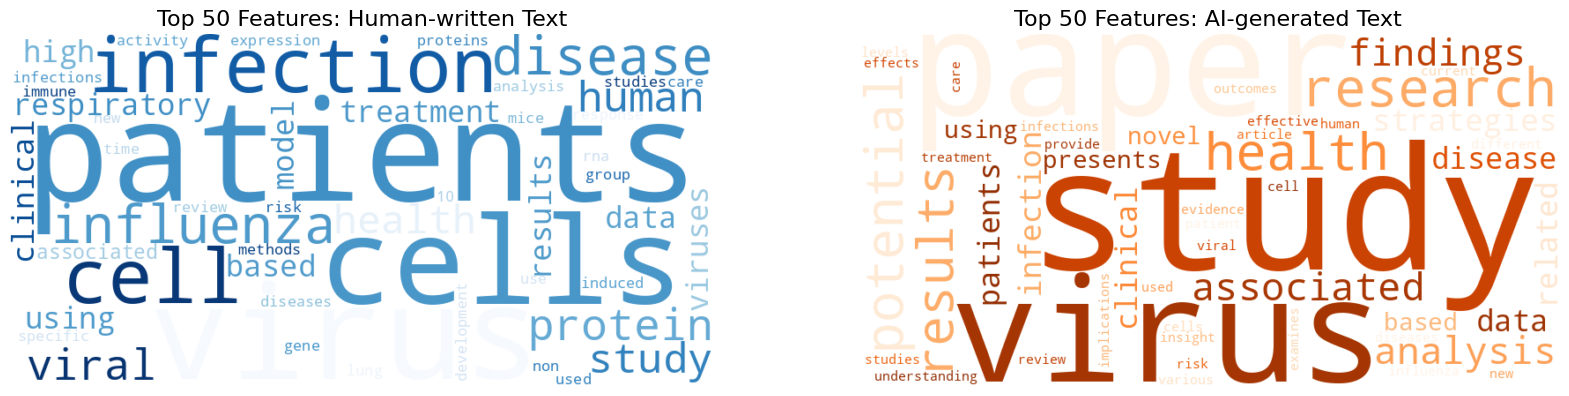

In [ ]:
plt.figure(figsize=(20,10))

# Human
plt.subplot(1,2,1)
plt.imshow(wc_human, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Features: Human-written Text', fontsize=16)

# AI
plt.subplot(1,2,2)
plt.imshow(wc_ai, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Features: AI-generated Text', fontsize=16)

plt.show()


# Logistic Regressin with L2 regularization

In [ ]:
# with l2 regularization
model_l2 = LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000)

In [ ]:
model_l2.fit(x_train_tfidf, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
y_val_pred = model_l2.predict(x_val_tfidf)
print("Validation Accuracy (L2):", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy (L2): 0.9724806201550388
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1290
           1       0.98      0.96      0.97      1290

    accuracy                           0.97      2580
   macro avg       0.97      0.97      0.97      2580
weighted avg       0.97      0.97      0.97      2580



In [ ]:
y_test_prob=model_l2.predict_proba(x_test_tfidf)[:,1]

fpr, tpr, thresholds = roc_curve(y_val, y_test_prob)
auc = roc_auc_score(y_val, y_test_prob)
# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LR with L2')
plt.legend()
plt.grid(True)
plt.show()

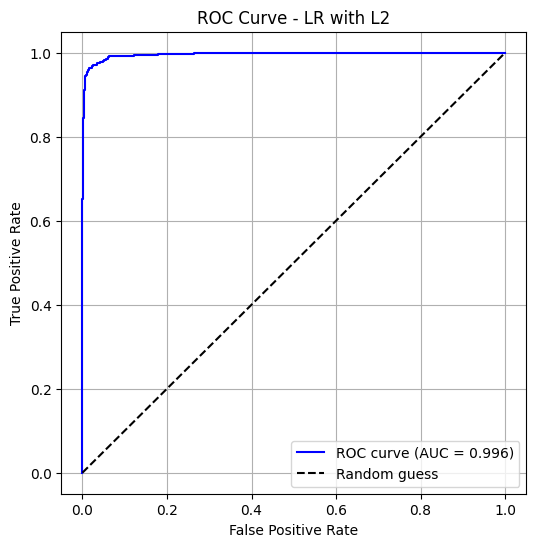

In [ ]:
y_val_proba = model_l2.predict_proba(x_val_tfidf)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

auc = roc_auc_score(y_val, y_val_proba)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LR with L2')
plt.legend()
plt.grid(True)
plt.show()

Train Loss: 0.12233626604429612
Validation Loss: 0.1331250678417348


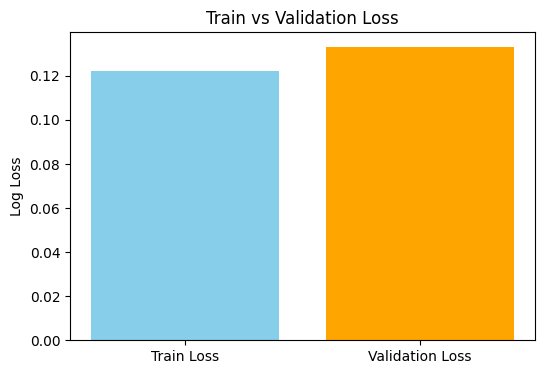

In [ ]:
y_train_proba = model_l2.predict_proba(x_train_tfidf)
y_val_proba   = model_l2.predict_proba(x_val_tfidf)

# Compute log loss
train_loss = log_loss(y_train, y_train_proba)
val_loss   = log_loss(y_val, y_val_proba)

print("Train Loss:", train_loss)
print("Validation Loss:", val_loss)

# Plotting
plt.figure(figsize=(6,4))
plt.bar(['Train Loss', 'Validation Loss'], [train_loss, val_loss], color=['skyblue', 'orange'])
plt.ylabel('Log Loss')
plt.title('Train vs Validation Loss')
plt.show()

# Logistic Regression without l2 regularization

In [ ]:
# without regualrization
model_no_l2 = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)


In [ ]:
model_no_l2.fit(x_train_tfidf, y_train)

LogisticRegression(max_iter=1000, penalty=None)

In [ ]:
y_val_pred = model_no_l2.predict(x_val_tfidf)
print("Validation Accuracy (wihout l2):", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy (wihout l2): 0.9697674418604652
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1290
           1       0.97      0.97      0.97      1290

    accuracy                           0.97      2580
   macro avg       0.97      0.97      0.97      2580
weighted avg       0.97      0.97      0.97      2580



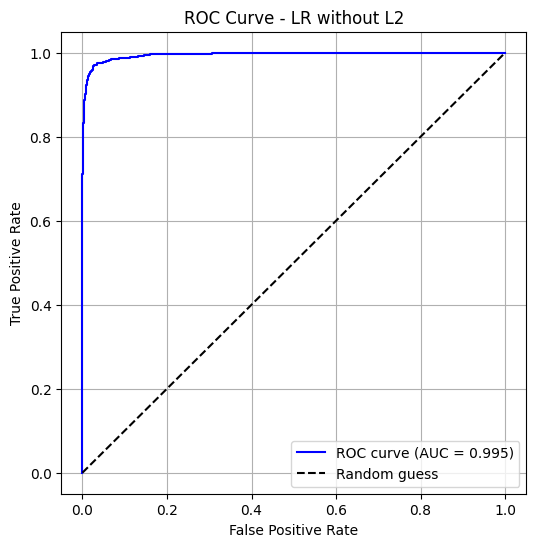

In [ ]:
y_val_proba = model_no_l2.predict_proba(x_val_tfidf)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

auc = roc_auc_score(y_val, y_val_proba)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LR without L2')
plt.legend()
plt.grid(True)
plt.show()

# Prediction on test set

In [ ]:
y_test_predict=model_l2.predict(x_test_tfidf)
print("Test accuracy (L2):", accuracy_score(y_test, y_test_predict))
print(classification_report(y_test, y_test_predict))

Test accuracy (L2): 0.9720962678758284
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1434
           1       0.97      0.97      0.97      1433

    accuracy                           0.97      2867
   macro avg       0.97      0.97      0.97      2867
weighted avg       0.97      0.97      0.97      2867



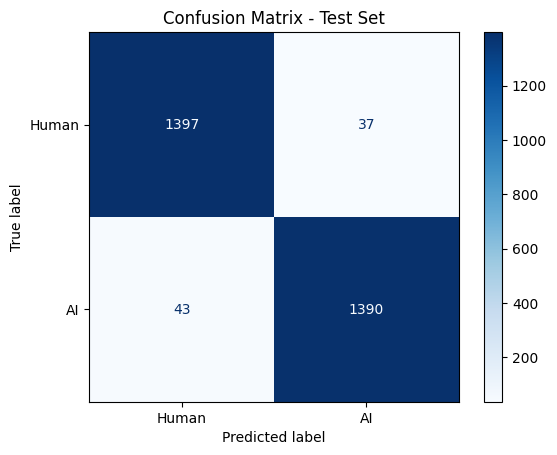

In [ ]:
confusionMatrix= confusion_matrix(y_test, y_test_predict)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=['Human', 'AI'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [ ]:
y_test_proba = model_l2.predict_proba(x_test_tfidf)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

auc = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_samples = [
    "The study analyzed how influenza infection affects respiratory activity in human cells.",
    "Clinical results show that patients with viral infections respond well to this treatment.",
    "Researchers observed a high expression of protein in lung cells of mice induced with the virus.",
    "The data from these studies associated the specific RNA gene with immune response in patients.",
    "Our analysis of viral proteins provides new insights into disease development and health risk.",
    "Illuminating the Deep: The Biochemical Mechanisms and Evolutionary Utility of Bioluminescence Abstract Bioluminescence, the production and emission of light by living organisms, serves as a critical biological tool across diverse taxa, particularly within marine environments. This phenomenon occurs through a highly efficient chemical reaction involving the oxidation of a light-emitting pigment, luciferin, catalyzed by the enzyme luciferase. While frequently observed in deep-sea cephalopods and teleost fish, bioluminescence also manifests in terrestrial fungi and insects, such as fireflies. Evolutionarily, this cold light is utilized for a variety of survival strategies, including predator deterrence via startle responses, prey attraction through luring mechanisms, and intraspecific communication for mating. This abstract explores the metabolic costs associated with light production and the convergent evolution that has allowed bioluminescence to arise independently dozens of times across the tree of life."
]

In [ ]:
sample=vectorizer.transform(test_samples)

In [ ]:
model_l2.predict(sample)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
ap_score = average_precision_score(y_test, y_test_proba)


In [ ]:
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='blue', label=f'PR curve (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve – Test Set')
plt.legend()
plt.grid(True)
plt.show()
